In [2]:
import numpy as np
from scipy.stats import norm
from sklearn.linear_model import LinearRegression
from matplotlib import pyplot as plt
import pandas as pd
from tqdm import tqdm

# Longstaff Schwartz Options Pricing

Summary of the algorithm:
1. Generate stock paths using GBM
2. Compute a matrix of payoffs $P$
3. Create a matrix of cashflows $C$, and set the final columns to the final payoffs
4. Backpropagate through the matrix, column by column. For cases where the option is ITM, want to estimate $\hat V_n = \mathbb E [e^{-r\Delta t} V_{n+1} \mid S_n]$. Compute coef. for $e^{-r \Delta t} V_{n + 1} = \psi(S_n)$, where $\psi$ is some kernel for a linear regression (typically polynomial of order 2)
5. Set $C_{i,j} = \max(\hat V_{n}, P_{n})$. If $P_n > \hat V_n$ then exercise the option and set all future cash flows to 0.
6. Continue backpropagating, filling $C$ until $t = 0$
7. Discount all cash flows to $t = 0$ and take the average to get the option price

In [3]:
class LongstaffSchwartzOption:
    def __init__(self, S0, K, r, sigma, T, n_steps, n_paths, option_type='put'):
        self.S0 = S0
        self.K = K
        self.r = r
        self.sigma = sigma
        self.T = T
        self.n_steps = n_steps
        self.n_paths = n_paths
        self.dt = T/n_steps
        self.option_type = option_type.lower()
        
        self.stock_paths = self._generate_paths()
        
    def _generate_paths(self):
        """Generate stock price paths using geometric Brownian motion"""
        Z = np.random.standard_normal((self.n_paths, self.n_steps))
        
        stock = np.zeros((self.n_paths, self.n_steps + 1))
        stock[:, 0] = self.S0
        
        for t in range(1, self.n_steps + 1):
            stock[:, t] = stock[:, t-1] * np.exp(
                (self.r - 0.5 * self.sigma**2) * self.dt + 
                self.sigma * np.sqrt(self.dt) * Z[:, t-1]
            )
            
        return stock
    
    def _payoff(self, stock_price):
        """Calculate the payoff for the option"""
        if self.option_type == 'put':
            return np.maximum(self.K - stock_price, 0)
        else:  # call option
            return np.maximum(stock_price - self.K, 0)
    
    def price(self):
        """
        Price the American option using the Longstaff-Schwartz algorithm
        """
        cash_flows = np.zeros((self.n_paths, self.n_steps + 1))
        cash_flows[:, -1] = self._payoff(self.stock_paths[:, -1])
        for t in range(self.n_steps - 1, 0, -1):
            current_prices = self.stock_paths[:, t]
            exercise_value = self._payoff(current_prices)
            
            if self.option_type == 'put':
                itm = current_prices < self.K
            else:
                itm = current_prices > self.K
                
            if sum(itm) > 0:
                future_cf = cash_flows[:, t+1:].sum(axis=1) * np.exp(-self.r * self.dt)
                
                X = np.column_stack([
                    np.ones(sum(itm)),
                    current_prices[itm],
                    current_prices[itm]**2
                ])
                
                reg = LinearRegression().fit(X, future_cf[itm])
                continuation_value = np.zeros(self.n_paths)
                continuation_value[itm] = reg.predict(X)
                
                exercise_decision = exercise_value > continuation_value
                cash_flows[:, t] = np.where(
                    exercise_decision,
                    exercise_value,
                    0
                )
                
                cash_flows[:, t+1:] = np.where(
                    exercise_decision.reshape(-1, 1),
                    0,
                    cash_flows[:, t+1:]
                )
        
        discount_factors = np.exp(-self.r * self.dt * np.arange(0, self.n_steps + 1))
        option_price = np.mean(cash_flows @ discount_factors)
        return option_price

S0 = 100  
K = 95   
r = 0.1 
sigma = 0.3 
T = 1.0   
n_steps = 50  
n_paths = 50000 
    
option = LongstaffSchwartzOption(
    S0=S0,
    K=K,
    r=r,
    sigma=sigma,
    T=T,
    n_steps=n_steps,
    n_paths=n_paths,
    option_type='put'
)
    
price = option.price()
print(f"American put option price: {price:.4f}")

American put option price: 6.2045


In [4]:
class LongstaffSchwartzNormRegOption:
    def __init__(self, S0, K, r, sigma, T, n_steps, n_paths, norm_var=0.1, option_type='put'):
        """
        Longstaff-Schwartz option pricer with probabilistic (partial) exercise
        """
        self.S0 = S0
        self.K = K
        self.r = r
        self.sigma = sigma
        self.T = T
        self.n_steps = n_steps
        self.n_paths = n_paths
        self.dt = T / n_steps
        self.norm_var = norm_var
        self.option_type = option_type.lower()
        
        self.stock_paths = self._generate_paths()
        
    def _generate_paths(self):
        Z = np.random.standard_normal((self.n_paths, self.n_steps))
        stock = np.zeros((self.n_paths, self.n_steps + 1))
        stock[:, 0] = self.S0
        
        for t in range(1, self.n_steps + 1):
            stock[:, t] = stock[:, t-1] * np.exp(
                (self.r - 0.5 * self.sigma**2) * self.dt +
                self.sigma * np.sqrt(self.dt) * Z[:, t-1]
            )
            
        return stock
    
    def _payoff(self, stock_price):
        if self.option_type == 'put':
            return np.maximum(self.K - stock_price, 0)
        else:  # call option
            return np.maximum(stock_price - self.K, 0)
    
    def price(self):
        """
        In this version the recursion is:
            V_t = p_t * payoff_t + (1 - p_t) * exp(-r*dt) * V_{t+1}, 
        where p_t (obtained from a normal CDF) is interpreted as the fraction
        exercised immediately.
        """
        payoff_matrix = np.zeros((self.n_paths, self.n_steps + 1))
        for t in range(self.n_steps + 1):
            payoff_matrix[:, t] = self._payoff(self.stock_paths[:, t])
        
        V = payoff_matrix[:, -1]
        
        for t in range(self.n_steps - 1, -1, -1):
            current_prices = self.stock_paths[:, t]
            current_payoff = payoff_matrix[:, t]
            
            discounted_V = np.exp(-self.r * self.dt) * V
            
            if self.option_type == 'put':
                itm = current_prices < self.K
            else:
                itm = current_prices > self.K
                
            continuation_est = np.copy(discounted_V)
            if np.sum(itm) > 0:
                X = np.column_stack([
                    np.ones(np.sum(itm)),
                    current_prices[itm],
                    current_prices[itm]**2
                ])
                y = discounted_V[itm]
                reg = LinearRegression().fit(X, y)
                continuation_est[itm] = reg.predict(X)
            
            p = np.zeros(self.n_paths)
            p[itm] = norm.cdf((current_payoff[itm] - continuation_est[itm]) / np.sqrt(self.norm_var))
            
            V = p * current_payoff + (1 - p) * discounted_V
        
        option_price = np.mean(V)
        return option_price

S0 = 100   
K = 95    
r = 0.1   
sigma = 0.3 
T = 1.0    
n_steps = 500
n_paths = 50000  
norm_var = 0.01 

option = LongstaffSchwartzNormRegOption(
    S0=S0,
    K=K,
    r=r,
    sigma=sigma,
    T=T,
    n_steps=n_steps,
    n_paths=n_paths,
    norm_var=norm_var,
    option_type='put'
)

price = option.price()
print(f"Modified American put option price: {price:.4f}")

Modified American put option price: 6.1776


### Sensitivity Analysis

In [11]:
S0 = 100
K = 95
r = 0.05
sigma = 0.4
T = 1.0
n_steps = 100
n_paths = 10000

# Values of norm_var to test
norm_vars = [0.0001, 0.001, 0.01, 0.1, 1.0]

# Number of independent simulation runs for each norm_var.
n_simulations = 10

# Dictionaries to store the simulation prices for each norm_var for both methods.
prices_standard = {nv: [] for nv in norm_vars}
prices_normreg  = {nv: [] for nv in norm_vars}

# Run the simulations.
for nv in (norm_vars):
    print(f"Running simulations for norm_var = {nv}")
    for sim in tqdm(range(n_simulations)):
        # Standard LS (binary exercise); here the norm_var parameter is ignored.
        standard_option = LongstaffSchwartzOption(S0, K, r, sigma, T, n_steps, n_paths, option_type='put')
        price_standard = standard_option.price()
        prices_standard[nv].append(price_standard)
        
        # NormReg LS (probabilistic/partial exercise) using the current norm_var.
        normreg_option = LongstaffSchwartzNormRegOption(S0, K, r, sigma, T, n_steps, n_paths, norm_var=nv, option_type='put')
        price_normreg = normreg_option.price()
        prices_normreg[nv].append(price_normreg)

# Build a results table (using pandas DataFrame) to display mean and std. deviation.
results = []
for nv in norm_vars:
    mean_std = np.mean(prices_standard[nv])
    std_std = np.std(prices_standard[nv])
    mean_norm = np.mean(prices_normreg[nv])
    std_norm = np.std(prices_normreg[nv])
    
    results.append({
        'norm_var': nv,
        'Method': 'Standard LS',
        'Mean Price': mean_std,
        'Std Dev': std_std
    })
    results.append({
        'norm_var': nv,
        'Method': 'NormReg LS',
        'Mean Price': mean_norm,
        'Std Dev': std_norm
    })

df_results = pd.DataFrame(results)
print("\nResults Table:")
print(df_results)

Running simulations for norm_var = 0.0001


100%|███████████████████████████████████████████| 10/10 [00:05<00:00,  1.79it/s]


Running simulations for norm_var = 0.001


100%|███████████████████████████████████████████| 10/10 [00:04<00:00,  2.02it/s]


Running simulations for norm_var = 0.01


100%|███████████████████████████████████████████| 10/10 [00:05<00:00,  1.95it/s]


Running simulations for norm_var = 0.1


100%|███████████████████████████████████████████| 10/10 [00:04<00:00,  2.09it/s]


Running simulations for norm_var = 1.0


100%|███████████████████████████████████████████| 10/10 [00:04<00:00,  2.04it/s]


Results Table:
   norm_var       Method  Mean Price   Std Dev
0    0.0001  Standard LS   11.155745  0.140915
1    0.0001   NormReg LS   11.109565  0.097849
2    0.0010  Standard LS   11.157287  0.114883
3    0.0010   NormReg LS   11.218165  0.126668
4    0.0100  Standard LS   11.121605  0.155494
5    0.0100   NormReg LS   11.058701  0.088043
6    0.1000  Standard LS   11.039925  0.159295
7    0.1000   NormReg LS   11.134568  0.123845
8    1.0000  Standard LS   11.088096  0.115985
9    1.0000   NormReg LS   10.608818  0.129009


In [42]:
from tqdm import tqdm

100%|███████████████████████████████████████| 1000/1000 [00:40<00:00, 24.92it/s]


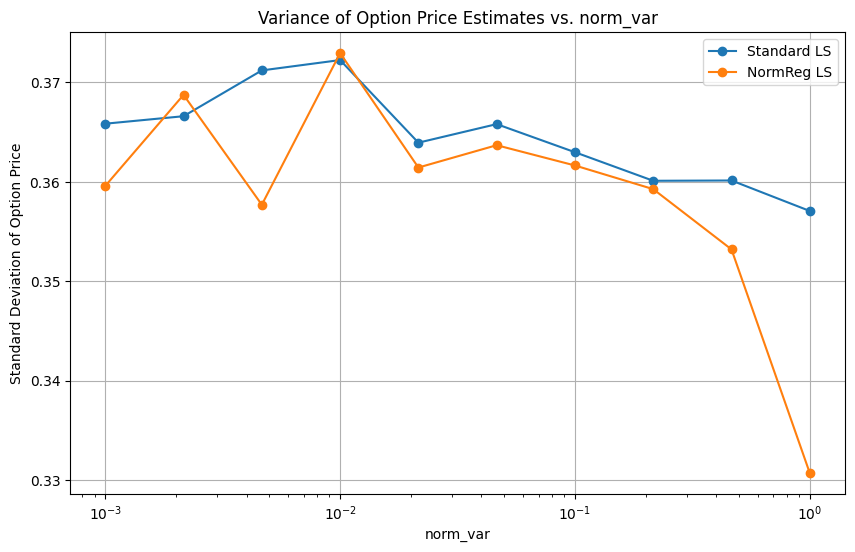

In [43]:
# Option parameters
S0 = 100
K = 95
r = 0.1
sigma = 0.3
T = 1.0
n_steps = 100
n_paths = 500

# Define a grid of norm_var values (logarithmically spaced)
norm_vars = np.logspace(-3, 0, 10)  # From 0.001 to 1.0

n_simulations = 1000  # Number of independent simulation runs for each norm_var

# Containers to store the standard deviation of estimated option prices
std_dev_standard = []  # For the standard LS method (binary exercise)
std_dev_normreg  = []  # For the NormReg LS method (partial exercise)

# Also store the mean prices (for reference)
mean_standard = []
mean_normreg = []

# Grid search over norm_vars
for nv in norm_vars:
    prices_standard = []
    prices_normreg  = []
    
    for sim in tqdm(range(n_simulations)):
        # Standard LS method (binary exercise) -- norm_var is not used in its decision.
        standard_option = LongstaffSchwartzOption(S0, K, r, sigma, T, n_steps, n_paths, option_type='put')
        price_std = standard_option.price()
        prices_standard.append(price_std)
        
        # NormReg LS method (partial exercise) using the current norm_var.
        normreg_option = LongstaffSchwartzNormRegOption(S0, K, r, sigma, T, n_steps, n_paths, norm_var=nv, option_type='put')
        price_norm = normreg_option.price()
        prices_normreg.append(price_norm)
    
    # Compute and store the standard deviation (as a measure of variance) of option price estimates.
    std_dev_standard.append(np.std(prices_standard))
    std_dev_normreg.append(np.std(prices_normreg))
    
    # Also store mean prices (optional)
    mean_standard.append(np.mean(prices_standard))
    mean_normreg.append(np.mean(prices_normreg))

# Plot the standard deviation (variance) vs norm_var for both methods.
plt.figure(figsize=(10, 6))
plt.plot(norm_vars, std_dev_standard, marker='o', label='Standard LS')
plt.plot(norm_vars, std_dev_normreg, marker='o', label='NormReg LS')
plt.xscale('log')  # Use logarithmic scale for norm_var axis
plt.xlabel('norm_var')
plt.ylabel('Standard Deviation of Option Price')
plt.title('Variance of Option Price Estimates vs. norm_var')
plt.legend()
plt.grid(True)
plt.show()


See if using the same random numbers is a fairer comparison:

100%|███████████████████████████████████████| 1000/1000 [00:17<00:00, 56.12it/s]


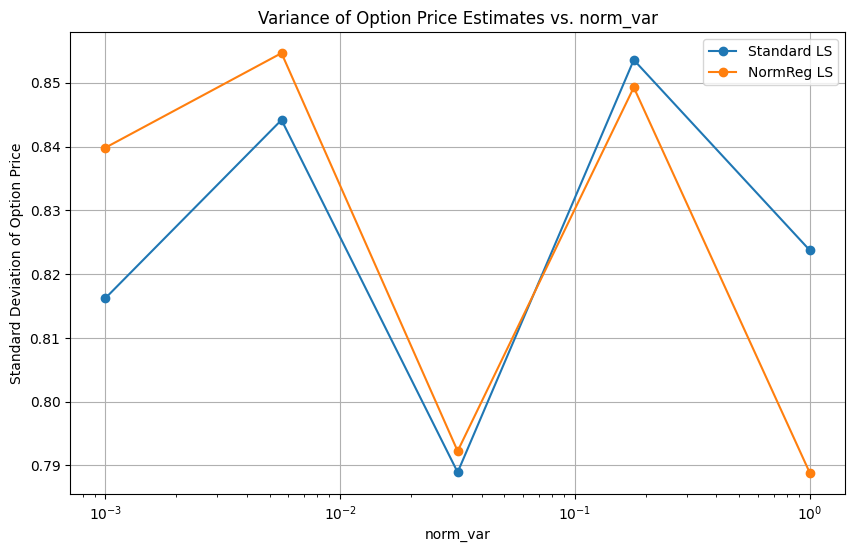

In [45]:
# Option parameters
S0 = 100
K = 95
r = 0.1
sigma = 0.3
T = 1.0
n_steps = 50
n_paths = 100

# Define a grid of norm_var values (logarithmically spaced)
norm_vars = np.logspace(-3, 0, 5)  # From 0.001 to 1.0

n_simulations = 1000  # Number of independent simulation runs for each norm_var

# Containers to store standard deviations (a measure of variance)
std_dev_standard = []  # Standard LS (binary exercise)
std_dev_normreg  = []  # NormReg LS (partial exercise)

# Also store mean prices (for reference)
mean_standard = []
mean_normreg = []

# Grid search over norm_vars
for nv in norm_vars:
    prices_standard = []
    prices_normreg  = []
    
    for sim in tqdm(range(n_simulations)):
        # Generate a random seed for this simulation run.
        seed = np.random.randint(0, 10**9)
        
        # Set the seed and run Standard LS
        np.random.seed(seed)
        standard_option = LongstaffSchwartzOption(S0, K, r, sigma, T, n_steps, n_paths, option_type='put')
        price_std = standard_option.price()
        prices_standard.append(price_std)
        
        # Reset the seed so the same random numbers are used for NormReg LS.
        np.random.seed(seed)
        normreg_option = LongstaffSchwartzNormRegOption(S0, K, r, sigma, T, n_steps, n_paths, norm_var=nv, option_type='put')
        price_norm = normreg_option.price()
        prices_normreg.append(price_norm)
    
    # Compute and store the standard deviation (variance) and mean of the prices
    std_dev_standard.append(np.std(prices_standard))
    std_dev_normreg.append(np.std(prices_normreg))
    mean_standard.append(np.mean(prices_standard))
    mean_normreg.append(np.mean(prices_normreg))

# Plot the standard deviation vs. norm_var for both methods.
plt.figure(figsize=(10, 6))
plt.plot(norm_vars, std_dev_standard, marker='o', label='Standard LS')
plt.plot(norm_vars, std_dev_normreg, marker='o', label='NormReg LS')
plt.xscale('log')  # Logarithmic scale for norm_var
plt.xlabel('norm_var')
plt.ylabel('Standard Deviation of Option Price')
plt.title('Variance of Option Price Estimates vs. norm_var')
plt.legend()
plt.grid(True)
plt.show()

It seems like there's more of a dependence on the random numbers being generated than anything so let's keep going with that.

In [14]:
S0 = 100
K = 95
r = 0.1
sigma = 0.3
T = 1.0
n_steps = 100
n_paths = 10000

norm_vars = np.logspace(-5, 2, 10)
n_simulations = 250 

std_dev_standard = []  
std_dev_normreg  = [] 
mean_standard = []
mean_normreg = []

for nv in norm_vars:
    prices_standard = []
    prices_normreg  = []
    
    for sim in tqdm(range(n_simulations)):
        seed = np.random.randint(0, 10**9)
        
        # Use the same seed for both methods so that they use identical stock paths (high sensitivity to random numbers)
        np.random.seed(seed)
        standard_option = LongstaffSchwartzOption(S0, K, r, sigma, T, n_steps, n_paths, option_type='put')
        price_std = standard_option.price()
        prices_standard.append(price_std)
        
        np.random.seed(seed)
        normreg_option = LongstaffSchwartzNormRegOption(S0, K, r, sigma, T, n_steps, n_paths, norm_var=nv, option_type='put')
        price_norm = normreg_option.price()
        prices_normreg.append(price_norm)
    
    # Record the standard deviation and mean for each norm_var
    std_dev_standard.append(np.std(prices_standard))
    std_dev_normreg.append(np.std(prices_normreg))
    mean_standard.append(np.mean(prices_standard))
    mean_normreg.append(np.mean(prices_normreg))

results = []
for i, nv in enumerate(norm_vars):
    results.append({
        'norm_var': nv,
        'Method': 'Standard LS',
        'Mean Price': mean_standard[i],
        'Std Dev': std_dev_standard[i]
    })
    results.append({
        'norm_var': nv,
        'Method': 'NormReg LS',
        'Mean Price': mean_normreg[i],
        'Std Dev': std_dev_normreg[i]
    })

df_results = pd.DataFrame(results)
print("Results Table:")
print(df_results)


100%|█████████████████████████████████████████| 250/250 [03:16<00:00,  1.27it/s]

Results Table:
      norm_var       Method  Mean Price   Std Dev
0     0.000010  Standard LS    6.178952  0.072763
1     0.000010   NormReg LS    6.178409  0.073674
2     0.000060  Standard LS    6.179701  0.078835
3     0.000060   NormReg LS    6.177973  0.078723
4     0.000359  Standard LS    6.182564  0.080295
5     0.000359   NormReg LS    6.181029  0.080465
6     0.002154  Standard LS    6.167580  0.083856
7     0.002154   NormReg LS    6.164825  0.084413
8     0.012915  Standard LS    6.184683  0.081471
9     0.012915   NormReg LS    6.179960  0.081135
10    0.077426  Standard LS    6.180641  0.076120
11    0.077426   NormReg LS    6.158272  0.073207
12    0.464159  Standard LS    6.182833  0.080642
13    0.464159   NormReg LS    5.974951  0.077759
14    2.782559  Standard LS    6.169749  0.086390
15    2.782559   NormReg LS    4.007694  0.068243
16   16.681005  Standard LS    6.185574  0.078112
17   16.681005   NormReg LS    2.217087  0.019136
18  100.000000  Standard LS    6.17

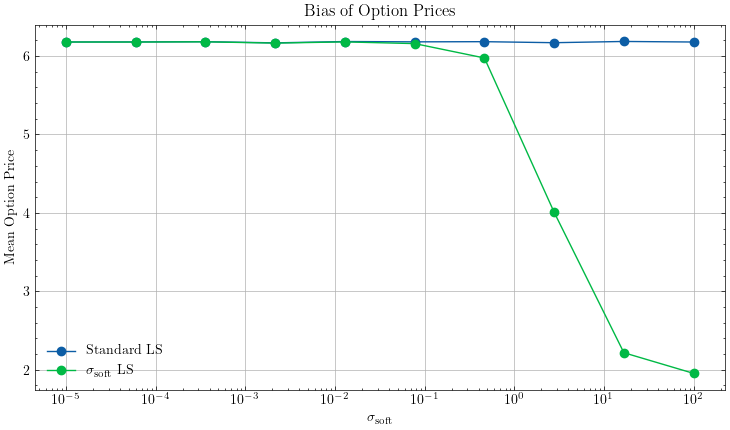

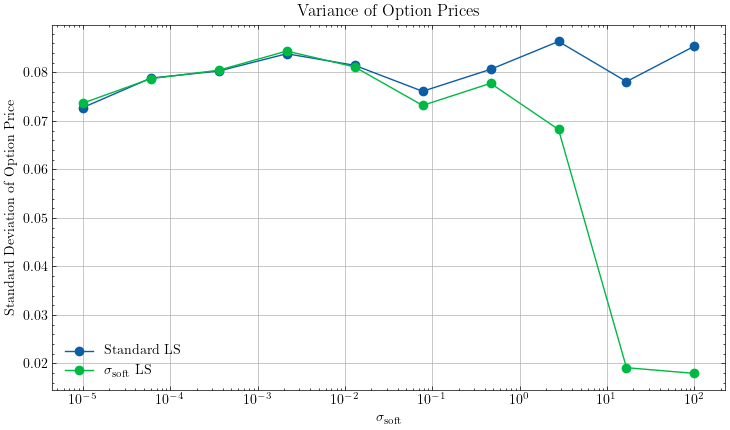

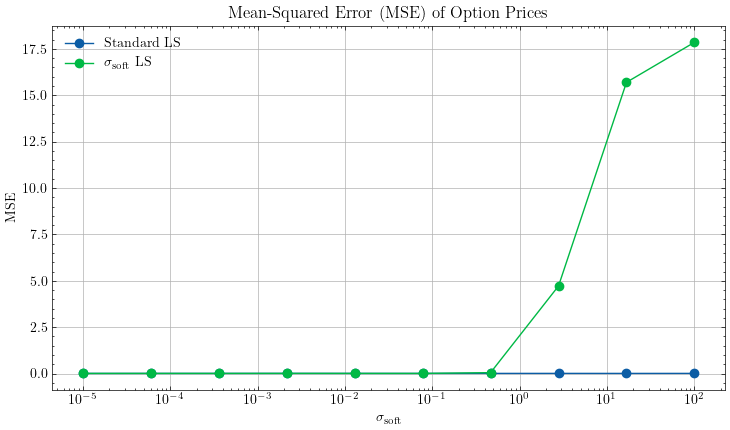

In [16]:
import numpy as np
import matplotlib.pyplot as plt
import scienceplots

plt.style.use(['science'])

true_price = np.mean(mean_standard)

# ----- Bias Plot -----
fig_bias, ax_bias = plt.subplots(figsize=(7.5, 4.5))
ax_bias.plot(norm_vars, mean_standard, marker='o', label='Standard LS')
ax_bias.plot(norm_vars, mean_normreg, marker='o', label=r'$\sigma_{\mathrm{soft}}$ LS')
ax_bias.set_xscale('log')
ax_bias.set_xlabel(r'$\sigma_{\mathrm{soft}}$')
ax_bias.set_ylabel('Mean Option Price')
ax_bias.set_title('Bias of Option Prices')
ax_bias.legend()
ax_bias.grid(True)
fig_bias.tight_layout()
fig_bias.savefig('bias_plot.pdf', format='pdf', bbox_inches='tight')


# ----- Variance Plot -----
fig_var, ax_var = plt.subplots(figsize=(7.5, 4.5))
ax_var.plot(norm_vars, std_dev_standard, marker='o', label='Standard LS')
ax_var.plot(norm_vars, std_dev_normreg, marker='o', label=r'$\sigma_{\mathrm{soft}}$ LS')
ax_var.set_xscale('log')
ax_var.set_xlabel(r'$\sigma_{\mathrm{soft}}$')
ax_var.set_ylabel('Standard Deviation of Option Price')
ax_var.set_title('Variance of Option Prices')
ax_var.legend()
ax_var.grid(True)
fig_var.tight_layout()
fig_var.savefig('variance_plot.pdf', format='pdf', bbox_inches='tight')


# ----- MSE Plot -----
fig_mse, ax_mse = plt.subplots(figsize=(7.5, 4.5))
mse_standard = (np.array(mean_standard) - true_price)**2 + np.array(std_dev_standard)**2
mse_normreg  = (np.array(mean_normreg)  - true_price)**2 + np.array(std_dev_normreg)**2
ax_mse.plot(norm_vars, mse_standard, marker='o', label='Standard LS')
ax_mse.plot(norm_vars, mse_normreg,  marker='o', label=r'$\sigma_{\mathrm{soft}}$ LS')
ax_mse.set_xscale('log')
ax_mse.set_xlabel(r'$\sigma_{\mathrm{soft}}$')
ax_mse.set_ylabel('MSE')
ax_mse.set_title('Mean-Squared Error (MSE) of Option Prices')
ax_mse.legend()
ax_mse.grid(True)
fig_mse.tight_layout()
fig_mse.savefig('mse_plot.pdf', format='pdf', bbox_inches='tight')

plt.show()
